In [1]:
import os
import json
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from pyproj import Transformer
from tqdm import tqdm
import pickle

In [2]:
# 获取当前日期
def get_dtime():
    # 例如20240516
    import datetime
    dtime = datetime.datetime.now().strftime('%Y%m%d')
    return dtime

In [3]:
# 导入autogluon模型
model_path = r"F:\cache_data\zone_ana\sb\modle\autogluon_type_2"

In [4]:
# 砂岩
sy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'sdt'))
sy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'fzrt'))
sy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'zrt'))
# 碳酸岩
tsy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'sdt'))
tsy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'fzrt'))
tsy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'zrt'))
# 第四纪红色粘土
hnt_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'sdt'))
hnt_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'fzrt'))
hnt_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'zrt'))
# 泥页岩
nyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'sdt'))
nyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'fzrt'))
nyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'zrt'))
# 紫红色砂页岩
zhsyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'sdt'))
zhsyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'fzrt'))
zhsyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'zrt'))
# 河流冲积物
hlcjw_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hlcjw'),'sdt'))
hlcjw_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hlcjw'),'fzrt'))
# 砂页岩
syy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'sdt'))
syy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'fzrt'))
syy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'zrt'))

In [5]:
# 获取特征函数

def get_feature_names(predictor):
    feature_names = predictor.feature_metadata_in.get_features()
    return feature_names
sdt_feature_names = syy_sdt_predictor.feature_metadata_in.get_features()
print("SDT",sdt_feature_names)
fzrt_feature_names = syy_fzrt_predictor.feature_metadata_in.get_features()
print("FZRT",fzrt_feature_names)
zrt_feature_names = syy_zrt_predictor.feature_metadata_in.get_features()
print("ZRT",zrt_feature_names)

SDT ['analytical_hillshading', 'aspect', 'channel_network_base_level', 'channel_network_distance', 'convergence_index', 'dem', 'dz', 'dl', 'etp2022_1', 'etp2022_10', 'etp2022_11', 'etp2022_12', 'etp2022_2', 'etp2022_3', 'etp2022_4', 'etp2022_5', 'etp2022_6', 'etp2022_7', 'etp2022_8', 'etp2022_9', 'etp2022_mean', 'evi', 'lat', 'lon', 'lswi', 'ls_factor', 'mndwi', 'mrrtf', 'mrvbf', 'ndvi', 'ndwi', 'night2022', 'pca_1', 'pca_2', 'plan_curvature', 'pre2022_1', 'pre2022_10', 'pre2022_11', 'pre2022_12', 'pre2022_2', 'pre2022_3', 'pre2022_4', 'pre2022_5', 'pre2022_6', 'pre2022_7', 'pre2022_8', 'pre2022_9', 'pre2022_mean', 'profile_curvature', 'relative_slope_position', 'savi', 'slope', 'slope_postion_101_smooth', 'tmp2022_1', 'tmp2022_10', 'tmp2022_11', 'tmp2022_12', 'tmp2022_2', 'tmp2022_3', 'tmp2022_4', 'tmp2022_5', 'tmp2022_6', 'tmp2022_7', 'tmp2022_8', 'tmp2022_9', 'tmp2022_mean', 'topographic_wetness_index', 'total_catchment_area', 'valley_depth', 'vari']
FZRT ['analytical_hillshading', 

In [6]:
# 存放预测结果的路径
result_path =  r"F:\cache_data\zone_ana\sb\prediction_result"

In [7]:
# 读取数据集
feature_path = r"F:\cache_data\zone_ana\sb\prediction_data\result_20241029.csv"

In [8]:
feature_df = pd.read_csv(feature_path)

In [9]:
feature_df.shape[0]

192101

In [16]:
# 重命名列
# 保留名称中包含'MEAN'、'MAJORITY'和'PCT90'的列,删除其他列
keep_cols = ['FID', 'DLBM', 'DLMC', 'BZ', 'DLDM', 'DLDMN', 'gridcode', 'TDLYLX', 'MZMC']  # 保留的基础列
keep_cols.extend([col for col in feature_df.columns if 'MEAN' in col or 'MAJORITY' in col or 'PCT90' in col])  # 添加需要保留的特征列

# 只保留指定的列
feature_df = feature_df[keep_cols]

In [19]:
# 创建一个字典来存储新的列名映射
rename_dict = {}

# 遍历所有列名
for col in feature_df.columns:
    # 如果列名包含 _MEAN 或 _PCT90
    if '_MEAN' in col or '_PCT90' in col:
        # 获取基础名称（去掉后缀）
        base_name = col.replace('_MEAN', '').replace('_PCT90', '')
        
        # 如果基础名称已经在字典中且当前列包含PCT90
        if base_name in rename_dict.values() and '_PCT90' in col:
            # 用新列名替换旧的映射
            old_key = [k for k, v in rename_dict.items() if v == base_name][0]
            rename_dict.pop(old_key)
            rename_dict[col] = base_name
        # 如果基础名称还没有在字典中
        elif base_name not in rename_dict.values():
            rename_dict[col] = base_name

# 重命名列
feature_df = feature_df.rename(columns=rename_dict)

In [21]:
[_ for _ in feature_df.columns]

['FID',
 'DLBM',
 'DLMC',
 'BZ',
 'DLDM',
 'DLDMN',
 'gridcode',
 'TDLYLX',
 'MZMC',
 'analytical_hillshading_MEAN',
 'analytical_hillshading',
 'aspect_MEAN',
 'aspect',
 'channel_network_base_level_MEAN',
 'channel_network_base_level',
 'channel_network_distance_MEAN',
 'channel_network_distance',
 'convergence_index_MEAN',
 'convergence_index',
 'dem_MEAN',
 'dem',
 'dl_MEAN',
 'dl',
 'dz_MEAN',
 'dz',
 'etp2022_1_MEAN',
 'etp2022_1',
 'etp2022_10_MEAN',
 'etp2022_10',
 'etp2022_11_MEAN',
 'etp2022_11',
 'etp2022_12_MEAN',
 'etp2022_12',
 'etp2022_2_MEAN',
 'etp2022_2',
 'etp2022_3_MEAN',
 'etp2022_3',
 'etp2022_4_MEAN',
 'etp2022_4',
 'etp2022_5_MEAN',
 'etp2022_5',
 'etp2022_6_MEAN',
 'etp2022_6',
 'etp2022_7_MEAN',
 'etp2022_7',
 'etp2022_8_MEAN',
 'etp2022_8',
 'etp2022_9_MEAN',
 'etp2022_9',
 'etp2022_mean_MEAN',
 'etp2022_mean',
 'evi_MEAN',
 'evi',
 'lat_MEAN',
 'lat',
 'lon_MEAN',
 'lon',
 'lswi_MEAN',
 'lswi',
 'ls_factor_MEAN',
 'ls_factor',
 'mndwi_MEAN',
 'mndwi',
 'mrrt

In [22]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,FID,DLBM,DLMC,BZ,DLDM,DLDMN,gridcode,TDLYLX,MZMC,analytical_hillshading_MEAN,...,tmp2022_mean_MEAN,tmp2022_mean,topographic_wetness_index_MEAN,topographic_wetness_index,total_catchment_area_MEAN,total_catchment_area,valley_depth_MEAN,valley_depth,vari_MEAN,vari


In [23]:
# 选择数值类型的列
numeric_cols = feature_df.select_dtypes(include=[np.float64])

# 计算数值列的均值
mean_values = numeric_cols.mean()

# 用均值填充数值列的空值
feature_df[numeric_cols.columns] = numeric_cols.fillna(mean_values)

In [24]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,FID,DLBM,DLMC,BZ,DLDM,DLDMN,gridcode,TDLYLX,MZMC,analytical_hillshading_MEAN,...,tmp2022_mean_MEAN,tmp2022_mean,topographic_wetness_index_MEAN,topographic_wetness_index,total_catchment_area_MEAN,total_catchment_area,valley_depth_MEAN,valley_depth,vari_MEAN,vari


In [25]:
dataset = feature_df

In [26]:
dataset.columns

Index(['FID', 'DLBM', 'DLMC', 'BZ', 'DLDM', 'DLDMN', 'gridcode', 'TDLYLX',
       'MZMC', 'analytical_hillshading_MEAN',
       ...
       'tmp2022_mean_MEAN', 'tmp2022_mean', 'topographic_wetness_index_MEAN',
       'topographic_wetness_index', 'total_catchment_area_MEAN',
       'total_catchment_area', 'valley_depth_MEAN', 'valley_depth',
       'vari_MEAN', 'vari'],
      dtype='object', length=152)

In [27]:

duplicated_rows = dataset[dataset['FID'].duplicated(keep=False)]

In [28]:
duplicated_rows

,FID,DLBM,DLMC,BZ,DLDM,DLDMN,gridcode,TDLYLX,MZMC,analytical_hillshading_MEAN,...,tmp2022_mean_MEAN,tmp2022_mean,topographic_wetness_index_MEAN,topographic_wetness_index,total_catchment_area_MEAN,total_catchment_area,valley_depth_MEAN,valley_depth,vari_MEAN,vari


In [29]:
# 统计总数据中各个岩石类型的总数
value_counts_dict = dataset['MZMC'].value_counts().to_dict()
value_counts_dict

{'白云岩': 101197,
 '第四纪粘土': 26977,
 '灰岩': 20555,
 '砂页岩': 11476,
 '砂岩': 10750,
 '泥(页)岩': 6787,
 '河流冲积物': 5283,
 '紫色砂页岩': 4676,
 '第四纪红黏土': 1303,
 '变余砂岩': 1190,
 '板岩': 837,
 '酸性紫色砂页岩': 620,
 '砂砾岩': 403,
 '砾岩': 47}

In [31]:
# 筛选砂岩水稻土数据
sy_sdt_data = dataset[(dataset['TDLYLX']=='水稻土') 
                      & ((dataset['MZMC'] == '砂岩')|(dataset['MZMC'] == '变余砂岩'))]
# 筛砂岩选非自然土数据
sy_fzrt_data = dataset[(dataset['TDLYLX']=='非自然土') 
                       & ((dataset['MZMC'] == '砂岩')|(dataset['MZMC'] == '变余砂岩'))]
# 筛选自然土数据
sy_zrt_data = dataset[(dataset['TDLYLX']=='自然土')
                   & ((dataset['MZMC'] == '砂岩')|(dataset['MZMC'] == '变余砂岩'))]
print(sy_sdt_data.shape[0]+sy_fzrt_data.shape[0]+sy_zrt_data.shape[0],value_counts_dict['砂岩']+value_counts_dict['变余砂岩'])

11940 11940


In [32]:
# 筛选碳酸岩水稻土数据
tsy_sdt_data = dataset[(dataset['TDLYLX']=='水稻土') 
                      & ((dataset['MZMC'] == '白云岩')|(dataset['MZMC'] == '灰岩'))]

# 筛选碳酸岩选非自然土数据
tsy_fzrt_data = dataset[(dataset['TDLYLX']=='非自然土') 
                        & ((dataset['MZMC'] == '白云岩')|(dataset['MZMC'] == '灰岩'))]

# 筛选碳酸岩自然土数据
tsy_zrt_data = dataset[(dataset['TDLYLX']=='自然土')
                   & ((dataset['MZMC'] == '白云岩')|(dataset['MZMC'] == '灰岩'))]
print(tsy_sdt_data.shape[0]+tsy_fzrt_data.shape[0]+tsy_zrt_data.shape[0],value_counts_dict['白云岩']+value_counts_dict['灰岩'])

121752 121752


In [33]:
# 筛选第四系红粘土水稻土数据
hnt_sdt_data = dataset[(dataset['TDLYLX']=='水稻土') 
                      & ((dataset['MZMC'] == '第四纪粘土')|(dataset['MZMC'] == '第四纪红黏土'))]

# 筛选第四系红粘土非自然土数据
hnt_fzrt_data = dataset[(dataset['TDLYLX']=='非自然土') 
                       & ((dataset['MZMC'] == '第四纪粘土')|(dataset['MZMC'] == '第四纪红黏土'))]

# 筛选第四系红粘土自然土数据
hnt_zrt_data = dataset[(dataset['TDLYLX']=='自然土')
                   & ((dataset['MZMC'] == '第四纪粘土')|(dataset['MZMC'] == '第四纪红黏土'))]
print(hnt_sdt_data.shape[0]+hnt_fzrt_data.shape[0]+hnt_zrt_data.shape[0],value_counts_dict['第四纪红黏土']+value_counts_dict['第四纪粘土'])

28280 28280


In [39]:
# 筛选泥(页)岩水稻土数据
nyy_sdt_data = dataset[(dataset['TDLYLX']=='水稻土')
                   & ((dataset['MZMC'] == '泥(页)岩')|(dataset['MZMC'] == '板岩')|(dataset['MZMC'] == '砾岩'))]

# 筛选泥(页)岩非自然土数据
nyy_fzrt_data = dataset[(dataset['TDLYLX']=='非自然土')
                       & ((dataset['MZMC'] == '泥(页)岩')|(dataset['MZMC'] == '板岩')|(dataset['MZMC'] == '砾岩'))]

# 筛选泥(页)岩自然土数据
nyy_zrt_data = dataset[(dataset['TDLYLX']=='自然土')
                   & ((dataset['MZMC'] == '泥(页)岩')|(dataset['MZMC'] == '板岩')|(dataset['MZMC'] == '砾岩'))]
print(nyy_sdt_data.shape[0]+nyy_fzrt_data.shape[0]+nyy_zrt_data.shape[0],value_counts_dict['泥(页)岩']+value_counts_dict['板岩']+value_counts_dict['砾岩'])

7671 7671


In [35]:
# 筛选紫红色砂页岩水稻土数据
zhsyy_sdt_data = dataset[(dataset['TDLYLX']=='水稻土')
                      &((dataset['MZMC'] == '酸性紫色砂页岩')|(dataset['MZMC'] == '紫色砂页岩'))]

# 筛选紫红色砂页岩非自然土数据
zhsyy_fzrt_data = dataset[(dataset['TDLYLX']=='非自然土')
                       & ((dataset['MZMC'] == '酸性紫色砂页岩')|(dataset['MZMC'] == '紫色砂页岩'))]

# 筛选紫红色砂页岩自然土数据
zhsyy_zrt_data = dataset[(dataset['TDLYLX']=='自然土')
                   & ((dataset['MZMC'] == '酸性紫色砂页岩')|(dataset['MZMC'] == '紫色砂页岩'))]
print(zhsyy_sdt_data.shape[0]+zhsyy_fzrt_data.shape[0]+zhsyy_zrt_data.shape[0],value_counts_dict['酸性紫色砂页岩']+value_counts_dict['紫色砂页岩'])

5296 5296


In [37]:
# 筛选河流冲积物水稻土数据
hlcjw_sdt_data = dataset[(dataset['TDLYLX']=='水稻土') 
                      &(dataset['MZMC'] == '河流冲积物')]
# 筛选河流冲积物非自然土数据
hlcjw_fzrt_data = dataset[(dataset['TDLYLX']=='非自然土') 
                       & (dataset['MZMC'] == '河流冲积物')]
# 筛选河流冲积物自然土数据
hlcjw_zrt_data = dataset[(dataset['TDLYLX']=='自然土')
                   & (dataset['MZMC'] == '河流冲积物')]
print(hlcjw_sdt_data.shape[0]+hlcjw_fzrt_data.shape[0]+hlcjw_zrt_data.shape[0],value_counts_dict['河流冲积物'])

5283 5283


In [38]:
# 筛选砂页岩水稻土数据
syy_sdt_data = dataset[(dataset['TDLYLX']=='水稻土') 
                      & ((dataset['MZMC'] == '砂页岩')|(dataset['MZMC'] == '砂砾岩'))]

# 筛选砂页岩非自然土数据
syy_fzrt_data = dataset[(dataset['TDLYLX']=='非自然土') 
                       & ((dataset['MZMC'] == '砂页岩')|(dataset['MZMC'] == '砂砾岩'))]

# 筛选砂页岩自然土数据
syy_zrt_data = dataset[(dataset['TDLYLX']=='自然土')
                   & ((dataset['MZMC'] == '砂页岩')|(dataset['MZMC'] == '砂砾岩'))]
print(syy_sdt_data.shape[0]+syy_fzrt_data.shape[0]+syy_zrt_data.shape[0],value_counts_dict['砂页岩']+value_counts_dict['砂砾岩'])


11879 11879


In [43]:
# 查看各个数据集的大小
print('砂岩',sy_sdt_data.shape,sy_fzrt_data.shape,sy_zrt_data.shape)
print('碳酸盐岩',tsy_sdt_data.shape,tsy_fzrt_data.shape,tsy_zrt_data.shape)
print('第四纪红色粘土',hnt_sdt_data.shape,hnt_fzrt_data.shape,hnt_zrt_data.shape)
print('泥页岩',nyy_sdt_data.shape,nyy_fzrt_data.shape,nyy_zrt_data.shape)
print('紫红色砂(页)岩',zhsyy_sdt_data.shape,zhsyy_fzrt_data.shape,zhsyy_zrt_data.shape)
print('河流冲积物',hlcjw_sdt_data.shape)
print('砂(页)岩',syy_sdt_data.shape,syy_fzrt_data.shape,syy_zrt_data.shape)
# 计算总和
print(sy_sdt_data.shape[0]+sy_fzrt_data.shape[0]+sy_zrt_data.shape[0]+tsy_sdt_data.shape[0]+tsy_fzrt_data.shape[0]+tsy_zrt_data.shape[0]+hnt_sdt_data.shape[0]+hnt_fzrt_data.shape[0]+hnt_zrt_data.shape[0]+nyy_sdt_data.shape[0]+nyy_fzrt_data.shape[0]+nyy_zrt_data.shape[0]+zhsyy_sdt_data.shape[0]+zhsyy_fzrt_data.shape[0]+zhsyy_zrt_data.shape[0]+hlcjw_sdt_data.shape[0]+hlcjw_fzrt_data.shape[0]+ hlcjw_zrt_data.shape[0]+syy_sdt_data.shape[0]+syy_fzrt_data.shape[0]+syy_zrt_data.shape[0])
# 数据总和
feature_df.shape[0]


砂岩 (3154, 152) (2692, 152) (6094, 152)
碳酸盐岩 (14677, 152) (46554, 152) (60521, 152)
第四纪红色粘土 (4789, 152) (15926, 152) (7565, 152)
泥页岩 (1644, 152) (2349, 152) (3678, 152)
紫红色砂(页)岩 (1400, 152) (1961, 152) (1935, 152)
河流冲积物 (3309, 152)
砂(页)岩 (3600, 152) (2462, 152) (5817, 152)
192101


192101

In [44]:
# 获取对照字典
with open(r'D:\worker_code\Terrain_Test\data\soil_dict_20241029_sb.json', 'r') as f:
    soil_dict = json.load(f)
# 将键转为int
soil_dict = {int(k):v for k, v in soil_dict.items()}

In [45]:
zhsyy_sdt_predictor.model_names()

['NeuralNetFastAI',
 'RandomForestGini',
 'RandomForestEntr',
 'ExtraTreesGini',
 'ExtraTreesEntr',
 'NeuralNetTorch',
 'WeightedEnsemble_L2']

In [46]:
# 模型选择
# select_model = 'WeightedEnsemble_L2'
select_model = 'RandomForestEntr'

In [47]:
# 概率预测函数
def predict_top_classes(data, predictor,feature_names, model, top_n, soil_dict):
    """
    根据给定的AutoGluon模型，预测数据集中的前n个最可能的类别及其概率，并根据提供的字典转换类别编号为描述字符串。
    参数:
    data (DataFrame): 输入的数据集。
    predictor（model）: 对应的模型
    feature_names (list): 用于预测的特征名列表。
    model (str): 选择的模型名称。
    top_n (int): 需要返回的最高概率的类别数量。
    soil_dict (dict): 类别编号到描述字符串的映射字典。
    
    返回:
    DataFrame: 原始数据与预测结果合并后的DataFrame。
    """
    # 复制数据
    data = data.copy()
    # 预测概率
    pred_probs = predictor.predict_proba(data[feature_names], model=model)
    # 获取概率最高的前n个类别及其概率
    top_classes = pred_probs.apply(lambda x: pd.Series(x.nlargest(top_n).index.astype(int).tolist() + x.nlargest(top_n).values.tolist()), axis=1)
    # 重命名列
    class_cols = ['Class{}'.format(i+1) for i in range(top_n)]
    prob_cols = ['Prob{}'.format(i+1) for i in range(top_n)]
    top_classes.columns = class_cols + prob_cols
    # 转换类别编号为描述字符串
    for col in class_cols:
        top_classes[col] = top_classes[col].map(soil_dict)
    # 计算每个预测的熵
    entropy = pred_probs.apply(lambda x: -np.sum(x * np.log(x + 1e-9)), axis=1)
    top_classes['Entropy'] = entropy
    # 计算每个预测的不确定性（标准差）
    uncertainty = pred_probs.std(axis=1)
    top_classes['Uncertainty'] = uncertainty
    # 将新列添加到原有的DataFrame中
    return pd.concat([data, top_classes], axis=1)

In [48]:
sy_sdt_data.columns

Index(['FID', 'DLBM', 'DLMC', 'BZ', 'DLDM', 'DLDMN', 'gridcode', 'TDLYLX',
       'MZMC', 'analytical_hillshading_MEAN',
       ...
       'tmp2022_mean_MEAN', 'tmp2022_mean', 'topographic_wetness_index_MEAN',
       'topographic_wetness_index', 'total_catchment_area_MEAN',
       'total_catchment_area', 'valley_depth_MEAN', 'valley_depth',
       'vari_MEAN', 'vari'],
      dtype='object', length=152)

In [49]:
# 模型预测
sy_sdt_result_df = predict_top_classes(sy_sdt_data, sy_sdt_predictor,get_feature_names(sy_sdt_predictor), select_model, 2, soil_dict)
sy_fzrt_result_df = predict_top_classes(sy_fzrt_data, sy_fzrt_predictor,get_feature_names(sy_fzrt_predictor), select_model, 2, soil_dict)
sy_zrt_result_df = predict_top_classes(sy_zrt_data, sy_zrt_predictor,get_feature_names(sy_zrt_predictor), select_model, 2, soil_dict)

tsy_sdt_result_df = predict_top_classes(tsy_sdt_data, tsy_sdt_predictor,get_feature_names(tsy_sdt_predictor), select_model, 2, soil_dict)
tsy_fzrt_result_df = predict_top_classes(tsy_fzrt_data, tsy_fzrt_predictor,get_feature_names(tsy_fzrt_predictor), select_model, 2, soil_dict)
tsy_zrt_result_df = predict_top_classes(tsy_zrt_data, tsy_zrt_predictor,get_feature_names(tsy_zrt_predictor), select_model, 2, soil_dict)

hnt_sdt_result_df = predict_top_classes(hnt_sdt_data, hnt_sdt_predictor,get_feature_names(hnt_sdt_predictor), select_model, 2, soil_dict)
hnt_fzrt_result_df = predict_top_classes(hnt_fzrt_data, hnt_fzrt_predictor,get_feature_names(hnt_fzrt_predictor), select_model, 2, soil_dict)
hnt_zrt_result_df = predict_top_classes(hnt_zrt_data, hnt_zrt_predictor,get_feature_names(hnt_zrt_predictor), select_model, 2, soil_dict)

nyy_sdt_result_df = predict_top_classes(nyy_sdt_data, nyy_sdt_predictor,get_feature_names(nyy_sdt_predictor), select_model, 2, soil_dict)
nyy_fzrt_result_df = predict_top_classes(nyy_fzrt_data, nyy_fzrt_predictor,get_feature_names(nyy_fzrt_predictor), select_model, 2, soil_dict)
nyy_zrt_result_df = predict_top_classes(nyy_zrt_data, nyy_zrt_predictor,get_feature_names(nyy_zrt_predictor), select_model, 2, soil_dict)

zhsyy_sdt_result_df = predict_top_classes(zhsyy_sdt_data, zhsyy_sdt_predictor,get_feature_names(zhsyy_sdt_predictor), select_model, 2, soil_dict)
zhsyy_fzrt_result_df = predict_top_classes(zhsyy_fzrt_data, zhsyy_fzrt_predictor,get_feature_names(zhsyy_fzrt_predictor), select_model, 2, soil_dict)
zhsyy_zrt_result_df = predict_top_classes(zhsyy_zrt_data, zhsyy_zrt_predictor,get_feature_names(zhsyy_zrt_predictor), select_model, 2, soil_dict)

hlcjw_sdt_result_df = predict_top_classes(hlcjw_sdt_data, hlcjw_sdt_predictor,get_feature_names(hlcjw_sdt_predictor), select_model, 2, soil_dict)
hlcjw_fzrt_result_df = predict_top_classes(hlcjw_fzrt_data, hlcjw_fzrt_predictor,get_feature_names(hlcjw_fzrt_predictor), select_model, 2, soil_dict)
hlcjw_zrt_result_df = predict_top_classes(hlcjw_zrt_data, hlcjw_fzrt_predictor,get_feature_names(hlcjw_fzrt_predictor), select_model, 2, soil_dict)

syy_sdt_result_df = predict_top_classes(syy_sdt_data, syy_sdt_predictor,get_feature_names(syy_sdt_predictor), select_model, 2, soil_dict)
syy_fzrt_result_df = predict_top_classes(syy_fzrt_data, syy_fzrt_predictor,get_feature_names(syy_fzrt_predictor), select_model, 2, soil_dict)
syy_zrt_result_df = predict_top_classes(syy_zrt_data, syy_zrt_predictor,get_feature_names(syy_zrt_predictor), select_model, 2, soil_dict)

In [50]:
# 将所有的DataFrame放入一个列表中
dfs = [
    sy_sdt_result_df, sy_fzrt_result_df, sy_zrt_result_df,
    tsy_sdt_result_df, tsy_fzrt_result_df, tsy_zrt_result_df,
    hnt_sdt_result_df, hnt_fzrt_result_df, hnt_zrt_result_df,
    nyy_sdt_result_df, nyy_fzrt_result_df, nyy_zrt_result_df,
    zhsyy_sdt_result_df, zhsyy_fzrt_result_df, zhsyy_zrt_result_df,
    hlcjw_sdt_result_df,hlcjw_fzrt_result_df, hlcjw_zrt_result_df,
    syy_sdt_result_df, syy_fzrt_result_df, syy_zrt_result_df
]

# 使用pd.concat合并所有的DataFrame
result_df = pd.concat(dfs, ignore_index=True)


In [51]:
result_df.columns

Index(['FID', 'DLBM', 'DLMC', 'BZ', 'DLDM', 'DLDMN', 'gridcode', 'TDLYLX',
       'MZMC', 'analytical_hillshading_MEAN',
       ...
       'valley_depth_MEAN', 'valley_depth', 'vari_MEAN', 'vari', 'Class1',
       'Class2', 'Prob1', 'Prob2', 'Entropy', 'Uncertainty'],
      dtype='object', length=158)

In [52]:
# 获取指定列
result_df = result_df[['FID','Class1', 'Class2', 'Prob1','Prob2', 'Entropy', 'Uncertainty']]

In [53]:
search_dict = {'腐中层壤质黄色石灰土': ['石灰土', '黄色石灰土', '壤质黄色石灰土', '腐中层壤质黄色石灰土'], '中层壤质黄色石灰土': ['石灰土', '黄色石灰土', '壤质黄色石灰土', '中层壤质黄色石灰土'], '腐中层红泥质黄壤': ['黄壤', '典型黄壤', '红泥质黄壤', '腐中层红泥质黄壤'], '腐薄层硅质黄壤': ['黄壤', '典型黄壤', '硅质黄壤', '腐薄层硅质黄壤'], '腐中层砂泥质黄壤': ['黄壤', '典型黄壤', '砂泥质黄壤', '腐中层砂泥质黄壤'], '腐中层泥质黄壤': ['黄壤', '典型黄壤', '泥质黄壤', '腐中层泥质黄壤'], '腐中层壤质中性紫色土': ['紫色土', '中性紫色土', '壤质中性紫色土', '腐中层壤质中性紫色土'], '腐薄层壤质中性紫色土': ['紫色土', '中性紫色土', '壤质中性紫色土', '腐薄层壤质中性紫色土'], '中层壤质中性紫色土': ['紫色土', '中性紫色土', '黏质中性紫色土', '中层壤质中性紫色土'], '腐薄层壤质黄色石灰土': ['石灰土', '黄色石灰土', '壤质黄色石灰土', '腐薄层壤质黄色石灰土'], '腐薄层砂泥质黄壤': ['黄壤', '典型黄壤', '砂泥质黄壤', '腐薄层砂泥质黄壤'], '腐薄层红泥质黄壤': ['黄壤', '典型黄壤', '红泥质黄壤', '腐薄层红泥质黄壤'], '腐薄层泥质黄壤': ['黄壤', '典型黄壤', '泥质黄壤', '腐薄层泥质黄壤'], '薄层壤质黄色石灰土': ['石灰土', '黄色石灰土', '壤质黄色石灰土', '薄层壤质黄色石灰土'], '腐薄层壤质酸性紫色土': ['紫色土', '酸性紫色土', '壤质酸性紫色土', '腐薄层壤质酸性紫色土'], '腐厚层壤质黄色石灰土': ['石灰土', '黄色石灰土', '壤质黄色石灰土', '腐厚层壤质黄色石灰土'], '腐厚层红泥质黄壤': ['黄壤', '典型黄壤', '红泥质黄壤', '腐厚层红泥质黄壤'], '腐厚层砂泥质黄壤': ['黄壤', '典型黄壤', '砂泥质黄壤', '腐厚层砂泥质黄壤'], '腐厚层泥质黄壤': ['黄壤', '典型黄壤', '泥质黄壤', '腐厚层泥质黄壤'], '腐厚层壤质中性紫色土': ['紫色土', '中性紫色土', '壤质中性紫色土', '腐厚层壤质中性紫色土'], '厚层壤质中性紫色土': ['紫色土', '中性紫色土', '壤质中性紫色土', '厚层壤质中性紫色土'], '厚层壤质黄色石灰土': ['石灰土', '黄色石灰土', '壤质黄色石灰土', '厚层壤质黄色石灰土'], '薄层灰泥质黄壤': ['黄壤', '典型黄壤', '灰泥质黄壤', '薄层灰泥质黄壤'], '腐中层灰泥质黄壤': ['黄壤', '典型黄壤', '灰泥质黄壤', '腐中层灰泥质黄壤'], '腐中层硅质黄壤': ['黄壤', '典型黄壤', '硅质黄壤', '腐中层硅质黄壤'], '腐薄层灰泥质黄壤': ['黄壤', '典型黄壤', '灰泥质黄壤', '腐薄层灰泥质黄壤'], '中层灰泥质黄壤': ['黄壤', '典型黄壤', '灰泥质黄壤', '中层灰泥质黄壤'], '中层泥质黄壤': ['黄壤', '典型黄壤', '泥质黄壤', '中层泥质黄壤'], '腐厚层硅质黄壤': ['黄壤', '典型黄壤', '硅质黄壤', '腐厚层硅质黄壤'], '腐厚层灰泥质黄壤': ['黄壤', '典型黄壤', '灰泥质黄壤', '腐厚层灰泥质黄壤'], '中层红泥质黄壤': ['黄壤', '典型黄壤', '红泥质黄壤', '中层红泥质黄壤'], '中层砂质灰潮土': ['潮土', '灰潮土', '砂质灰潮土', '中层砂质灰潮土'], '中层砂泥质黄壤': ['黄壤', '典型黄壤', '砂泥质黄壤', '中层砂泥质黄壤'], '薄层泥质黄壤': ['黄壤', '典型黄壤', '泥质黄壤', '薄层泥质黄壤'], '中层黏质黄色石灰土': ['石灰土', '黄色石灰土', '黏质黄色石灰土', '中层黏质黄色石灰土'], '腐中层黏质黄色石灰土': ['石灰土', '黄色石灰土', '黏质黄色石灰土', '腐中层黏质黄色石灰土'], '薄层红泥质黄壤': ['黄壤', '典型黄壤', '红泥质黄壤', '薄层红泥质黄壤'], '薄层硅质黄壤': ['黄壤', '典型黄壤', '硅质黄壤', '薄层硅质黄壤'], '薄层壤质中性紫色土': ['紫色土', '中性紫色土', '壤质中性紫色土', '薄层壤质中性紫色土'], '腐中层壤质酸性紫色土': ['紫色土', '酸性紫色土', '壤质酸性紫色土', '腐中层壤质酸性紫色土'], '厚层红泥质黄壤': ['黄壤', '典型黄壤', '红泥质黄壤', '厚层红泥质黄壤'], '厚层砂泥质黄壤': ['黄壤', '典型黄壤', '砂泥质黄壤', '厚层砂泥质黄壤'], '厚层泥质黄壤': ['黄壤', '典型黄壤', '泥质黄壤', '厚层泥质黄壤'], '石灰泥田': ['水稻土', '潴育水稻土', '灰泥田', '石灰泥田'], '黄红泥田': ['水稻土', '潴育水稻土', '红泥田', '黄红泥田'], '潮泥砂田': ['水稻土', '潴育水稻土', '潮泥砂田', '潮泥砂田'], '潮泥田': ['水稻土', '潴育水稻土', '潮泥田', '潮泥田'], '黄渗红泥田': ['水稻土', '渗育水稻土', '渗红泥田', '黄渗红泥田'], '紫泥田': ['水稻土', '潴育水稻土', '紫泥田', '紫泥田'], '浅石灰泥田': ['水稻土', '淹育水稻土', '浅灰泥田', '浅石灰泥田'], '渗石灰泥田': ['水稻土', '渗育水稻土', '渗灰泥田', '渗石灰泥田'], '黄渗白粉泥田': ['水稻土', '渗育水稻土', '渗白粉泥田', '黄渗白粉泥田'], '黄渗砂泥田': ['水稻土', '渗育水稻土', '渗砂泥田', '黄渗砂泥田'], '渗紫泥田': ['水稻土', '渗育水稻土', '渗紫泥田', '渗紫泥田'], '黄砂泥田': ['水稻土', '潴育水稻土', '砂泥田', '黄砂泥田'], '黄鳝泥田': ['水稻土', '潴育水稻土', '鳝泥田', '黄鳝泥田'], '腐薄层黏质黄色石灰土': ['石灰土', '黄色石灰土', '黏质黄色石灰土', '腐薄层黏质黄色石灰土'], '黄灰泥田': ['水稻土', '潴育水稻土', '灰泥田', '黄灰泥田'], '黄渗鳝泥田': ['水稻土', '渗育水稻土', '渗鳝泥田', '黄渗鳝泥田'], '厚层灰泥质黄壤': ['黄壤', '典型黄壤', '灰泥质黄壤', '厚层灰泥质黄壤'], '厚层硅质黄壤': ['黄壤', '典型黄壤', '硅质黄壤', '厚层硅质黄壤'], '中层硅质黄壤': ['黄壤', '典型黄壤', '硅质黄壤', '中层硅质黄壤'], '腐厚层黏质黄色石灰土': ['石灰土', '黄色石灰土', '黏质黄色石灰土', '腐厚层黏质黄色石灰土'], '黄白粉泥田': ['水稻土', '潴育水稻土', '白粉泥田', '黄白粉泥田'], '黄浅砂泥田': ['水稻土', '淹育水稻土', '浅砂泥田', '黄浅砂泥田'], '黄渗灰泥田': ['水稻土', '渗育水稻土', '渗灰泥田', '黄渗灰泥田'], '黄浅白粉泥田': ['水稻土', '淹育水稻土', '浅白粉泥田', '黄浅白粉泥田'], '薄层砂泥质黄壤': ['黄壤', '典型黄壤', '砂泥质黄壤', '薄层砂泥质黄壤'], '腐薄层硅质黄棕壤': ['黄棕壤', '暗黄棕壤', '硅质暗黄棕壤', '腐薄层硅质黄棕壤'], '腐厚层泥质黄棕壤': ['黄棕壤', '暗黄棕壤', '泥质暗黄棕壤', '腐厚层泥质黄棕壤'], '腐中层硅质黄棕壤': ['黄棕壤', '暗黄棕壤', '硅质暗黄棕壤', '腐中层硅质黄棕壤'], '薄层泥质黄棕壤': ['黄棕壤', '暗黄棕壤', '泥质暗黄棕壤', '薄层泥质黄棕壤'], '腐薄层泥质黄棕壤': ['黄棕壤', '暗黄棕壤', '泥质暗黄棕壤', '腐薄层泥质黄棕壤'], '腐中层泥质黄棕壤': ['黄棕壤', '暗黄棕壤', '泥质暗黄棕壤', '腐中层泥质黄棕壤'], '黄浅鳝泥田': ['水稻土', '淹育水稻土', '浅鳝泥田', '黄浅鳝泥田'], '厚层砂质灰潮土': ['潮土', '灰潮土', '砂质灰潮土', '厚层砂质灰潮土'], '厚层黏质黄色石灰土': ['石灰土', '黄色石灰土', '黏质黄色石灰土', '厚层黏质黄色石灰土'], '黄石灰泥田': ['水稻土', '脱潜水稻土', '黄灰泥田', '黄石灰泥田'], '薄层壤质酸性紫色土': ['紫色土', '酸性紫色土', '壤质酸性紫色土', '薄层壤质酸性紫色土'], '酸紫泥田': ['水稻土', '潴育水稻土', '紫泥田', '酸紫泥田'], '酸渗紫泥田': ['水稻土', '渗育水稻土', '渗紫泥田', '酸渗紫泥田'], '黄浅灰泥田': ['水稻土', '淹育水稻土', '浅灰泥田', '黄浅灰泥田'], '漂石灰泥田': ['水稻土', '漂洗水稻土', '漂灰泥田', '漂石灰泥田'], '薄层黏质黄色石灰土': ['石灰土', '黄色石灰土', '黏质黄色石灰土', '薄层黏质黄色石灰土'], '腐薄层灰泥质石灰性粗骨土': ['粗骨土', '石灰性粗骨土', '灰泥质石灰性粗骨土', '腐薄层灰泥质石灰性粗骨土'], '薄层灰泥质石灰性粗骨土': ['粗骨土', '石灰性粗骨土', '灰泥质石灰性粗骨土', '薄层灰泥质石灰性粗骨土'], '薄层泥质酸性粗骨土': ['粗骨土', '酸性粗骨土', '泥质酸性粗骨土', '薄层泥质酸性粗骨土'], '腐薄层硅质酸性粗骨土': ['粗骨土', '酸性粗骨土', '硅质酸性粗骨土', '腐薄层硅质酸性粗骨土'], '腐中层黏质中性紫色土': ['紫色土', '中性紫色土', '黏质中性紫色土', '腐中层黏质中性紫色土']}


In [54]:
soil_type_dict = {}
for key in search_dict:
    soil_type_dict[key] = {"土类":search_dict[key][0],"亚类":search_dict[key][1],"土属":search_dict[key][2]}


In [55]:
# 使用 apply 方法结合 lambda 函数来获取对应的 '土类' 值
result_df = result_df.copy()
result_df['Class1_tl'] = result_df['Class1'].apply(lambda x: soil_type_dict.get(x, {}).get('土类', None))
result_df['Class1_yl'] = result_df['Class1'].apply(lambda x: soil_type_dict.get(x, {}).get('亚类', None))
result_df['Class1_ts'] = result_df['Class1'].apply(lambda x: soil_type_dict.get(x, {}).get('土属', None))


In [56]:
result_df

,FID,Class1,Class2,Prob1,Prob2,Entropy,Uncertainty,Class1_tl,Class1_yl,Class1_ts
0,2240,黄白粉泥田,黄渗白粉泥田,0.466667,0.460000,0.904469,0.225191,水稻土,潴育水稻土,白粉泥田
1,2242,黄白粉泥田,黄渗白粉泥田,0.496667,0.443333,0.877012,0.238211,水稻土,潴育水稻土,白粉泥田
2,2245,黄白粉泥田,黄渗白粉泥田,0.500000,0.400000,0.943348,0.208167,水稻土,潴育水稻土,白粉泥田
3,2246,黄白粉泥田,黄渗白粉泥田,0.636667,0.296667,0.828491,0.286764,水稻土,潴育水稻土,白粉泥田
4,2247,黄白粉泥田,黄渗白粉泥田,0.536667,0.326667,0.971485,0.200083,水稻土,潴育水稻土,白粉泥田
...,...,...,...,...,...,...,...,...,...,...
192096,191656,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.613333,0.286667,0.888256,0.259829,黄壤,典型黄壤,砂泥质黄壤
192097,191657,腐薄层砂泥质黄壤,腐中层砂泥质黄壤,0.553333,0.426667,0.769114,0.278648,黄壤,典型黄壤,砂泥质黄壤
192098,191691,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.676667,0.210000,0.838801,0.301238,黄壤,典型黄壤,砂泥质黄壤
192099,191699,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.680000,0.253333,0.790626,0.314395,黄壤,典型黄壤,砂泥质黄壤


In [57]:
# 保存数据
result_df.to_csv(os.path.join(result_path, f'prediction_class_{select_model}_{get_dtime()}.csv'),index=False)

In [59]:


def analyze_class_distribution(result_df):
    # 计算 Class1 的值计数
    class1_counts = result_df['Class1'].value_counts()
    
    # 计算 Class1 和 Class1_ts 的唯一值数量
    class1_unique_count = len(result_df['Class1'].unique())
    class1_ts_unique_count = len(result_df['Class1_ts'].unique())
    
    # 创建一个包含所有信息的 DataFrame
    summary_df = pd.DataFrame({
        'Class': class1_counts.index,
        'Count': class1_counts.values
    })
    
    # 添加百分比列
    summary_df['Percentage'] = summary_df['Count'] / summary_df['Count'].sum() * 100
    
    # 排序并重置索引
    summary_df = summary_df.sort_values('Count', ascending=False).reset_index(drop=True)
    
    
    return summary_df

# 使用示例
view_df = analyze_class_distribution(result_df)

In [60]:
view_df

,Class,Count,Percentage
0,腐中层壤质黄色石灰土,28588,14.881755
1,腐中层灰泥质黄壤,13671,7.116569
2,中层壤质黄色石灰土,13650,7.105637
3,腐薄层壤质黄色石灰土,12582,6.549680
4,中层红泥质黄壤,11671,6.075450
...,...,...,...
81,腐薄层硅质黄棕壤,32,0.016658
82,漂石灰泥田,29,0.015096
83,腐中层泥质黄棕壤,24,0.012493
84,腐中层黏质中性紫色土,24,0.012493


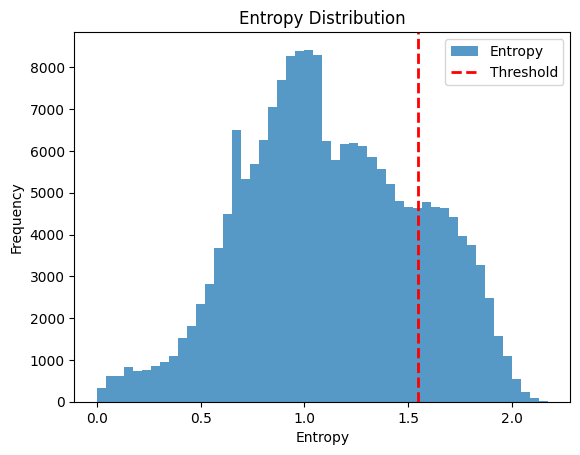

分界值: 1.5484870263804666


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 提取熵值
entropy = result_df['Entropy']

# 计算熵的均值和标准差
entropy_mean = entropy.mean()
entropy_std = entropy.std()
entropy_threshold = entropy_mean + entropy_std

# 绘制熵的分布图
plt.hist(entropy, bins=50, alpha=0.75, label='Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.axvline(entropy_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[entropy <= entropy_threshold]

# 输出结果
print(f"分界值: {entropy_threshold}")


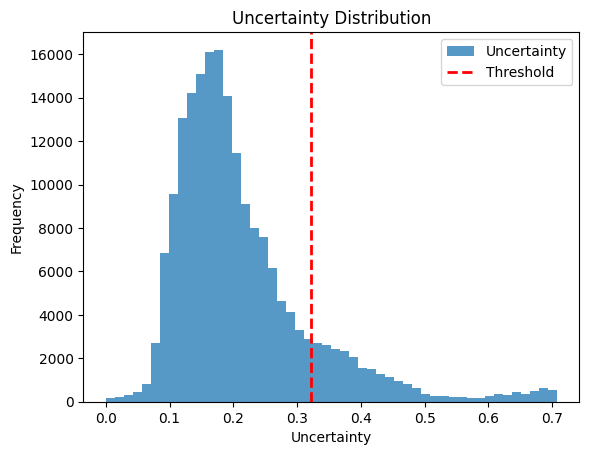

不确定性分界值: 0.3218404839022753


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
uncertainty = result_df['Uncertainty']
# 计算不确定性的均值和标准差
uncertainty_mean = uncertainty.mean()
uncertainty_std = uncertainty.std()
uncertainty_threshold = uncertainty_mean + uncertainty_std

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[uncertainty <= uncertainty_threshold]

# 输出结果
print(f"不确定性分界值: {uncertainty_threshold}")


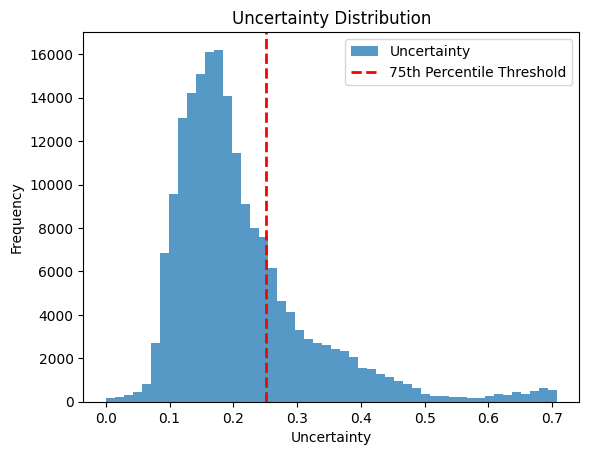

第75百分位数分界值: 0.250953733921051


In [63]:
# 计算第75百分位数
uncertainty_threshold_75 = np.percentile(uncertainty, 75)

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold_75, color='r', linestyle='dashed', linewidth=2, label='75th Percentile Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions_75 = result_df[uncertainty <= uncertainty_threshold_75]

# 输出结果
print(f"第75百分位数分界值: {uncertainty_threshold_75}")